In [1]:
import pickle
import pandas as pd
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = 'colab'  # Try this renderer in case plotly graphs don't show up

# Load results
with open('analysis_results.pkl', 'rb') as f:
    results = pickle.load(f)

# Access different components
composite_indices = results['composite_indices']
network_metrics = results['network_metrics']
spatial_stats = results['spatial_stats']
spatial_gdf = results['spatial_gdf']
network = results['network']
loadings = results['loadings']
importance = results['importance']

### INPUTS:

The pickle file contains several key objects from your analysis:

**composite_indices**: A pandas DataFrame containing the calculated indices for each NUTS2 region across your three pillars:
* Place-based Conditions (Basic_Needs, Access)
* Human & Social Capital (Education_Talent, Social_Capital)
* Economic Activity (Growth_Prosperity, Labor_Market)


**network_metrics**: A dictionary containing network analysis results, including:
* Density, clustering coefficients
* Centrality measures
* Significant correlations between indices
* Diagnostic information
  
**network**: A NetworkX graph object representing relationships between your indices
loadings: Factor analysis loadings showing how original variables contribute to composite indices
spatial_stats: Dictionary containing spatial autocorrelation measures:
* Global Moran's I
* Local Moran's I
* Associated p-values and z-scores

**spatial_gdf**: A GeoDataFrame combining your indices with NUTS2 geographical boundaries


# Visualisations

## 1. Correlation Analysis

*Method: Correlation matrices reveal the strength and direction of linear relationships between variables, ranging from -1 (perfect negative correlation) to +1 (perfect positive correlation).*

#### Key Interpretations:

- Strong positive correlations (> 0.7) suggest dimensions move together
- Weak correlations (< 0.3) suggest independent movement
- Negative correlations suggest trade-offs between dimensions

#### Critical Values:

p < 0.05 for statistical significance

Correlation coefficients:

* 0.1-0.3: weak correlation
* 0.3-0.5: moderate correlation
* 0.5: strong correlation

#### Research Significance:

- Tests decoupling hypothesis if economic and social dimensions show weak correlations
- Identifies potential complementarities or trade-offs between development dimensions
- Reveals potential clustering of development indicators

#### Example visualisations:

``` plot_composite_indices_heatmap() ```

* Purpose: Shows relationships between different dimensions of development
* Paper Connection: Tests the hypothesis of decoupling between different aspects of development
* Significance: Helps identify which dimensions move together vs independently

In [2]:
def plot_composite_indices_heatmap():
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        composite_indices.corr(), 
        annot=True, 
        cmap='RdBu_r',
        center=0
    )
    plt.title('Correlation between Composite Indices')
    plt.tight_layout()  # Add this
    plt.show()  # Make sure this is called

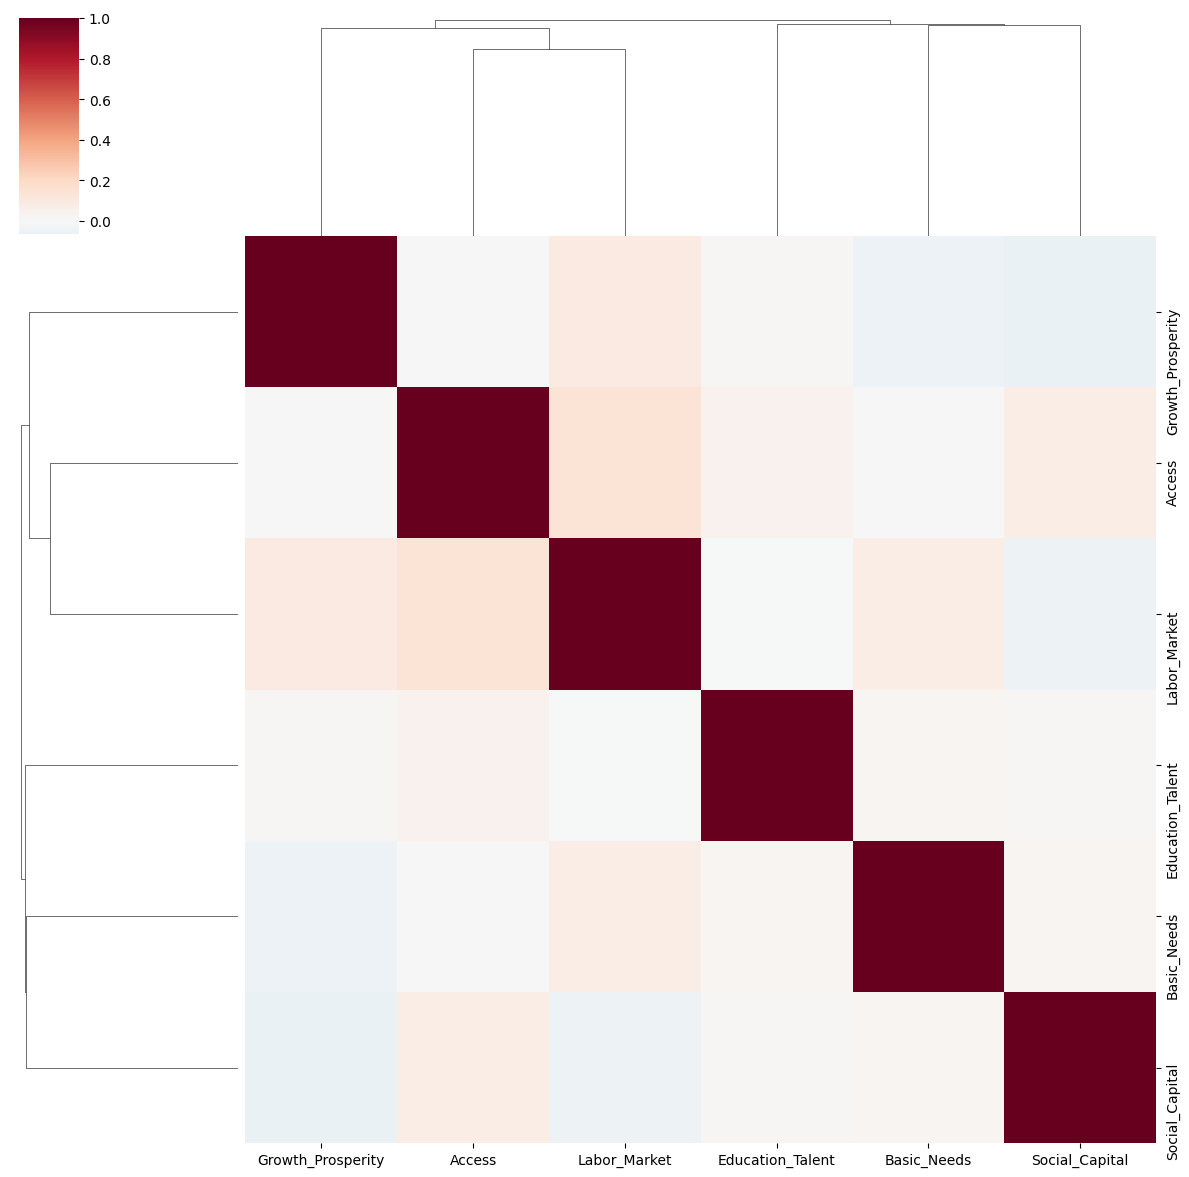

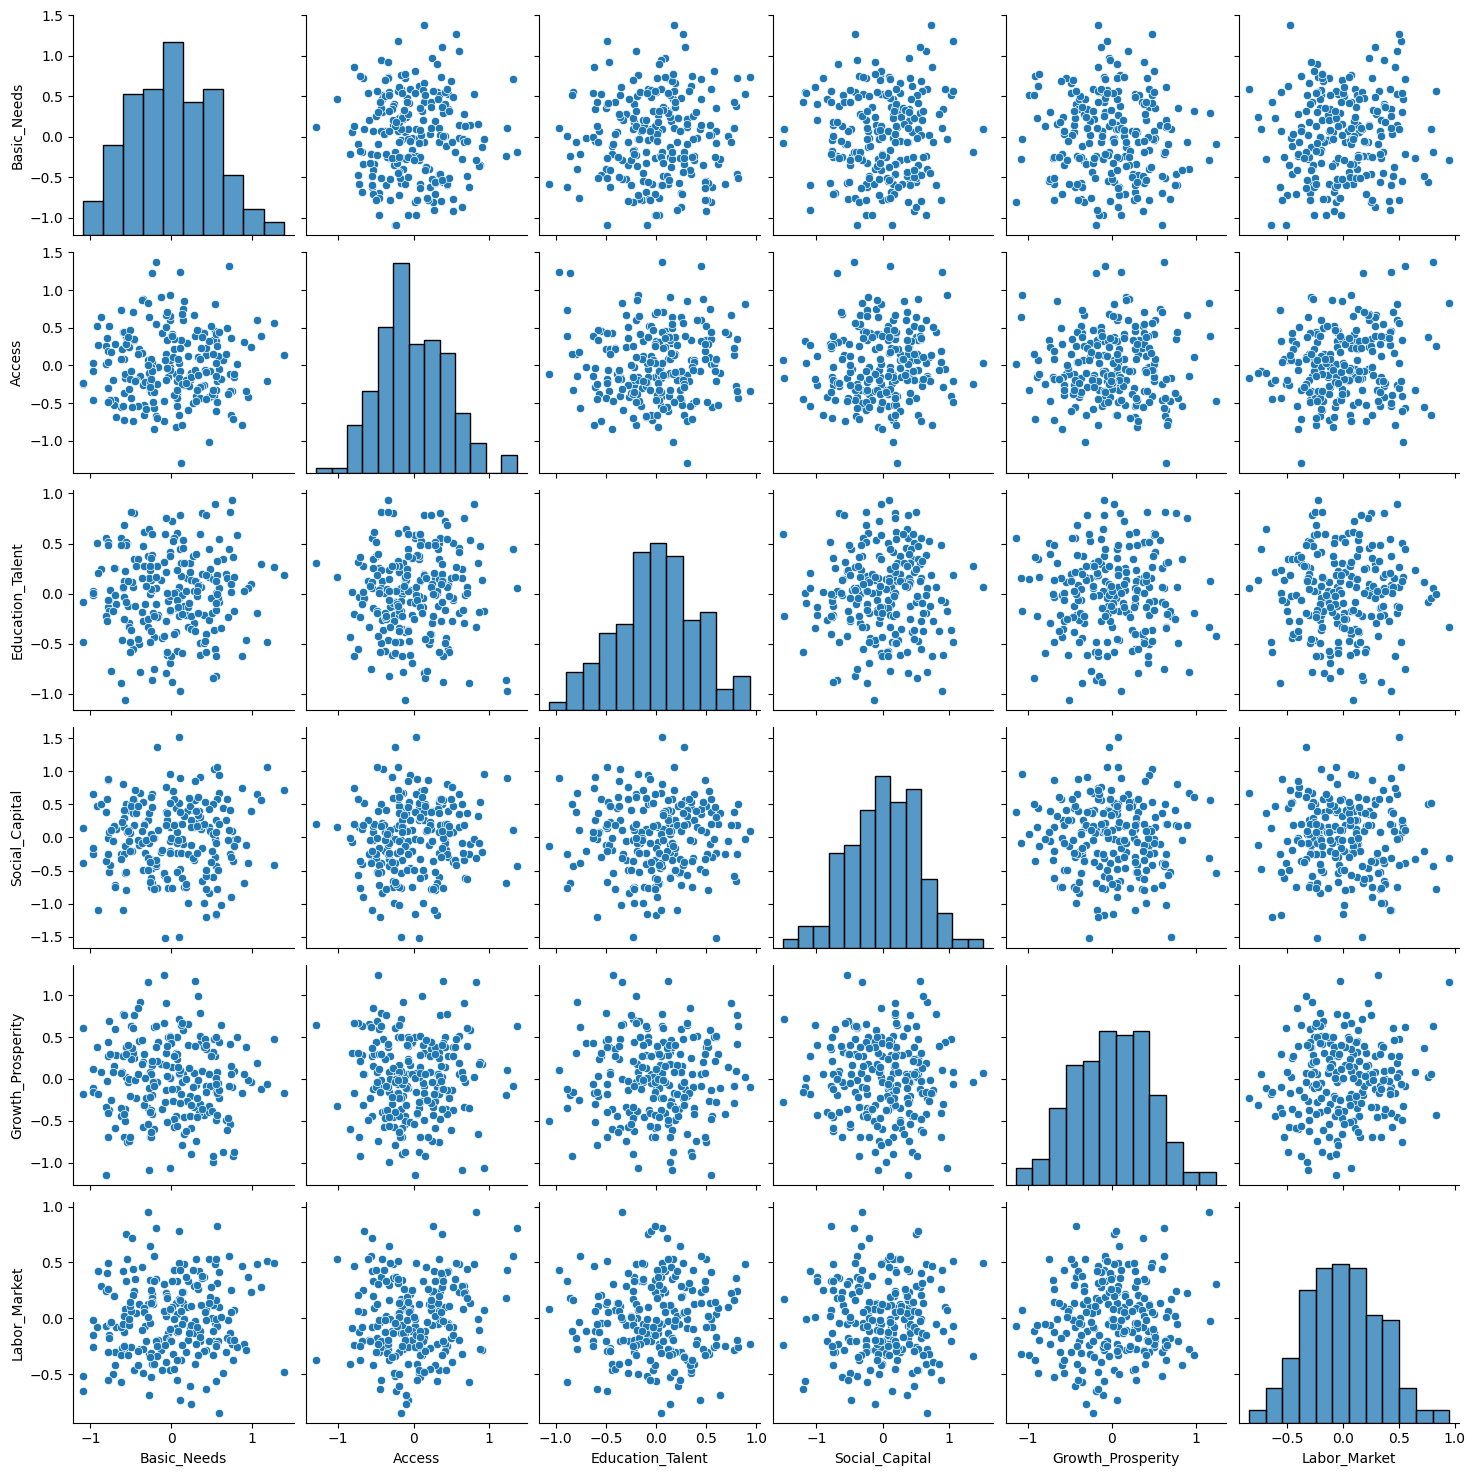

In [3]:
# Correlation matrix heatmap
sns.clustermap(
    composite_indices.corr(),
    cmap='RdBu_r',
    center=0,
    figsize=(12,12)
)

# Pairwise relationships
sns.pairplot(composite_indices)

## 2. Spatial Analysis

*Methods:*
*A. Global Moran's I*

- *Measures spatial autocorrelation across entire study area*
- *Values range from -1 (perfect dispersion) to +1 (perfect clustering)*

```python
from pysal.explore import esda
moran = esda.Moran(spatial_gdf[column], weights_matrix)
```

*B. Local Moran's I (LISA)*

- *Identifies local clusters and spatial outliers*
- *Produces cluster maps showing:*
1. *High-High clusters*
2. *Low-Low clusters*
3. *High-Low outliers*
4. *Low-High outliers*



#### Key Interpretations:

- Moran's I > 0: Positive spatial autocorrelation (clustering)
- Moran's I < 0: Negative spatial autocorrelation (dispersion)
- Moran's I ≈ 0: Random spatial pattern

#### Critical Values:

- Z-score > 1.96 or < -1.96 for statistical significance at p < 0.05
- Pseudo p-values from Monte Carlo simulation
- LISA cluster significance typically set at p < 0.05

#### Research Significance:

- Tests for systematic geographic patterns in development
- Identifies development clusters and lagging regions
- Shows potential spatial spillovers*

#### Example visualisations:

```python
plot_nuts2_choropleth()
plot_spatial_pattern() 
```

* Purpose: Visualises geographical distribution of each index
* Paper Connection: Identifies regional patterns and potential clusters
* Significance: Shows how development dimensions vary across space, crucial for understanding regional disparities

In [4]:
def plot_nuts2_choropleth(column, title=None):
    """
    Create a choropleth map for NUTS2 regions
    
    Parameters:
    column (str): Name of column to plot
    title (str): Optional custom title
    """
    # First convert to WGS84
    plotting_gdf = spatial_gdf.copy()
    plotting_gdf.geometry = plotting_gdf.geometry.to_crs('EPSG:4326')
    
    if title is None:
        title = f'Distribution of {column} across EU NUTS2 Regions'
        
    fig = px.choropleth(
        plotting_gdf,
        geojson=plotting_gdf.geometry,
        locations=plotting_gdf.index,
        color=column,
        title=title,
        color_continuous_scale="RdBu",
        hover_data=['NUTS_NAME', 'CNTR_CODE'],  
        labels={column: column.replace('_', ' ')}
    )
    
    # Update layout for better visualization
    fig.update_geos(
        fitbounds="locations",
        visible=False,
        resolution=50,
        scope="europe",
        showcoastlines=True,
        coastlinecolor="Black",
        showland=True,
        landcolor="white",
        showframe=False
    )
    
    fig.update_layout(
        margin={"r":0,"t":30,"l":0,"b":0},
        height=600
    )
    
    return fig

# Example usage for all composite indices:
for column in ['Basic_Needs', 'Access', 'Education_Talent', 
               'Social_Capital', 'Growth_Prosperity', 'Labor_Market']:
    fig = plot_nuts2_choropleth(column)
    fig.show()

In [14]:
def plot_spatial_pattern(column):
    # First merge spatial data with your indices
    merged_gdf = spatial_gdf.merge(
        composite_indices[column].to_frame(),
        left_index=True,
        right_index=True,
        how='left'
    )
    
    fig = px.choropleth(
        merged_gdf,
        locations=merged_gdf.index,
        color=column,
        scope="europe",
        title=f'Spatial Pattern of {column}',
        color_continuous_scale="RdBu_r"
    )
    fig.show()

def plot_network():
    pos = nx.spring_layout(network)
    
    edge_trace = go.Scatter(
        x=[], y=[], 
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines'
    )

    for edge in network.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_trace['x'] += tuple([x0, x1, None])
        edge_trace['y'] += tuple([y0, y1, None])

    node_trace = go.Scatter(
        x=[], y=[], 
        text=[],
        mode='markers+text',
        hoverinfo='text',
        marker=dict(size=20)
    )

    for node in network.nodes():
        x, y = pos[node]
        node_trace['x'] += tuple([x])
        node_trace['y'] += tuple([y])
        node_trace['text'] += tuple([node])

    fig = go.Figure(
        data=[edge_trace, node_trace],
        layout=go.Layout(
            showlegend=False,
            hovermode='closest',
            margin=dict(b=0,l=0,r=0,t=0)
        )
    )
    fig.show()


# Example usage
#plot_composite_indices_heatmap()
#plot_spatial_pattern('Basic_Needs')
plot_network()

In [15]:
# Distribution of indices across regions
for column in composite_indices.columns:
    plot_spatial_pattern(column)

# Spatial autocorrelation maps (using spatial_stats)

ValueError: Value of 'color' is not the name of a column in 'data_frame'. Expected one of ['NUTS_ID', 'LEVL_CODE', 'CNTR_CODE', 'NAME_LATN', 'NUTS_NAME', 'MOUNT_TYPE', 'URBN_TYPE', 'COAST_TYPE', 'geometry', 'Basic_Needs_x', 'Access', 'Education_Talent', 'Social_Capital', 'Growth_Prosperity', 'Labor_Market', 'Basic_Needs_y'] but received: Basic_Needs

## 3. Network Analysis

*Methods:*
*A. Network Construction*
* *Nodes: Development dimensions*
* *Edges: Significant correlations between dimensions*
* *Edge weights: Correlation strength*

*B. Centrality Measures*
```python
# Key centrality metrics
degree_centrality = nx.degree_centrality(network)
betweenness_centrality = nx.betweenness_centrality(network)
eigenvector_centrality = nx.eigenvector_centrality(network)
```

#### Key Interpretations:

* Degree Centrality: Direct connections/influence
* Betweenness Centrality: Bridge/mediator role
* Eigenvector Centrality: Connection to other important nodes

#### Critical Values:

* Network density (typically 0.2-0.3 for social networks)
* Clustering coefficient (> 0.3 indicates meaningful clustering)
* Centrality measures normalized to [0,1]

#### Research Significance:

* Shows which dimensions are most central to development
* Identifies key mediating factors
* Reveals development dimension clusters

#### Example visualisations:

``` plot_network() ```

* Purpose: Visualises interconnections between development dimensions
* Paper Connection: Demonstrates the ecosystem nature of development
* Significance: Shows which dimensions are most central/influential in the development system

In [19]:
# Centrality measures
centrality_df = pd.DataFrame({
    'degree': dict(nx.degree_centrality(network)),
    'betweenness': dict(nx.betweenness_centrality(network)),
    'eigenvector': dict(nx.eigenvector_centrality(network))
})
centrality_df

,degree,betweenness,eigenvector
Basic_Needs,0.0,0.0,0.000001
Access,0.2,0.0,0.707107
Education_Talent,0.0,0.0,0.000001
Social_Capital,0.0,0.0,0.000001
Growth_Prosperity,0.0,0.0,0.000001
Labor_Market,0.2,0.0,0.707107


## 4. Cluster Analysis

*Methods:*
*A. Hierarchical Clustering*
```python
linked = linkage(composite_indices, 'ward')  # Ward's minimum variance
```

*B. K-means clustering*
```python
kmeans = KMeans(n_clusters=k, random_state=42)
```

#### Key Interpretations:

* Dendrogram height: Dissimilarity between clusters
* Cluster silhouette scores: Cluster cohesion and separation
* Within-cluster sum of squares: Cluster compactness

#### Critical Values:

* Silhouette score > 0.5 indicates good clustering
* Optimal number of clusters often determined by:
1. Elbow method
2. Silhouette analysis
3. Gap statistic

#### Research Significance:

* Identifies distinct development patterns
* Shows how regions group naturally
* Reveals development typologies

#### Example visualisations:

``` plot_spatial_clusters() ```

* Purpose: Groups regions based on similar development patterns
* Paper Connection: Identifies distinct regional development typologies
* Significance: Helps understand if there are common development patterns or "clubs"

* Purpose: Groups regions based on similar development patterns
* Paper Connection: Identifies distinct regional development typologies
* Significance: Helps understand if there are common development patterns or "clubs"

In [20]:
def plot_spatial_clusters():
    """Plot spatial clustering of regions based on all indices"""
    from sklearn.preprocessing import StandardScaler
    from sklearn.cluster import KMeans
    
    # Prepare data for clustering
    cluster_data = spatial_gdf[['Basic_Needs', 'Access', 'Education_Talent', 
                              'Social_Capital', 'Growth_Prosperity', 'Labor_Market']]
    
    # Standardize the data
    scaler = StandardScaler()
    cluster_data_scaled = scaler.fit_transform(cluster_data)
    
    # Perform clustering
    kmeans = KMeans(n_clusters=5, random_state=42)
    spatial_gdf['Cluster'] = kmeans.fit_predict(cluster_data_scaled)
    
    # Plot clusters
    fig = px.choropleth(
        spatial_gdf,
        geojson=spatial_gdf.geometry,
        locations=spatial_gdf.index,
        color='Cluster',
        title='Regional Clusters Based on All Indices',
        color_continuous_scale="Viridis",
        hover_data=['NUTS_NAME', 'CNTR_CODE']
    )
    
    fig.update_geos(
        fitbounds="locations",
        visible=False,
        scope="europe",
        showcoastlines=True,
        coastlinecolor="Black",
        showland=True,
        landcolor="white",
        showframe=False
    )
    
    return fig

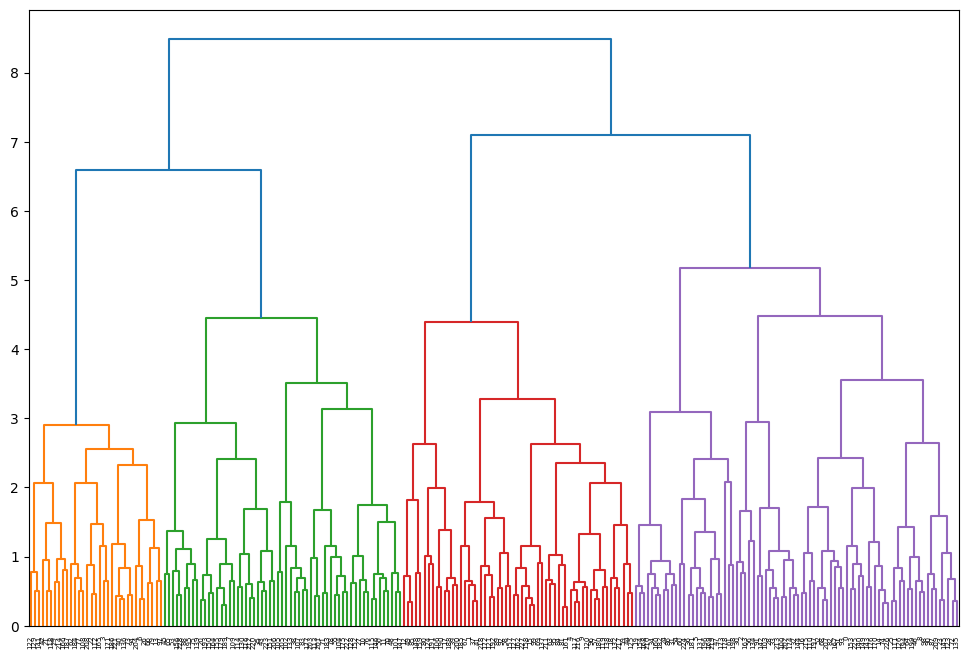

In [21]:
# Hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage
linked = linkage(composite_indices, 'ward')
plt.figure(figsize=(12, 8))
dendrogram(linked)
plt.show()

# K-means clustering
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
composite_indices['cluster'] = kmeans.fit_predict(composite_indices)

## 5. Bi-variate Relationship Analysis

*Methods:*
* *Scatter plots with trend lines*
* *Optional LOWESS smoothing for non-linear relationships*
* *Regression analysis with controls*

#### Key Interpretations:

* Slope: Direction and strength of relationship
* R²: Explained variance
* Residuals: Deviations from expected relationship

#### Critical Values:

* R² > 0.3 considered meaningful in social sciences
* p < 0.05 for statistical significance
* VIF < 5 for multicollinearity check

#### Research Significance:

* Tests specific hypotheses about development relationships
* Identifies non-linear patterns
* Shows outliers and special cases

#### Example visualisations:

``` plot_bivariate_relationship() ```

* Purpose: Detailed examination of relationships between specific indices
* Paper Connection: Explores specific hypotheses about development relationships
* Significance: Helps identify potential causal or structural relationships

In [22]:
def plot_bivariate_relationship(var1, var2):
    """Plot relationship between two variables with regional labels"""
    return px.scatter(
        spatial_gdf,
        x=var1,
        y=var2,
        hover_data=['NUTS_NAME', 'CNTR_CODE'],
        title=f'Relationship between {var1} and {var2}',
        trendline="ols",
        template="plotly_white"  # Add a template
    )

# Now try using it:
plot_bivariate_relationship('Basic_Needs', 'Social_Capital')